In [1]:
import numpy as np
import pickle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

## Data functions

In [2]:
def load_input_data(input_data):
    """
    Return input data as numpy array of [x-coordinate, y-coordinate]
    """
    
    # parse the input
    lines = input_data.split('\n')

    num_nodes = int(lines[0])

    nodes_array = np.zeros((num_nodes, 2))
    for i in range(num_nodes):
        line = lines[i+1]
        parts = line.split()
        nodes_array[i,:] = np.array([float(parts[0]), float(parts[1])])
        
    return nodes_array, num_nodes

In [85]:
input_file = open('data/tsp_1889_1','r').read()

In [86]:
nodes_array, num_nodes = load_input_data(input_file)
nodes_array

array([[12784., 10098.],
       [18704.,  8580.],
       [18704., 14234.],
       ...,
       [ 8304.,  6490.],
       [ 8304.,  7040.],
       [12784.,  4840.]])

## Distance matrix functions

In [ ]:
## consider sklearn.neighbors.KDTree in future to get k nearest neighbours in O(n log n) 
## rather than the O(n^2) distance matrix

In [87]:
distance_matrix = squareform(pdist(nodes_array, 'euclidean'))
distance_matrix

array([[    0.        ,  6111.52386889,  7221.69619965, ...,
         5752.22252699,  5424.18325649,  5258.        ],
       [ 6111.52386889,     0.        ,  5654.        , ...,
        10607.9262818 , 10513.40097209,  7002.42815029],
       [ 7221.69619965,  5654.        ,     0.        , ...,
        12966.47739365, 12645.69634303, 11103.76674827],
       ...,
       [ 5752.22252699, 10607.9262818 , 12966.47739365, ...,
            0.        ,   550.        ,  4774.19103095],
       [ 5424.18325649, 10513.40097209, 12645.69634303, ...,
          550.        ,     0.        ,  4991.03195742],
       [ 5258.        ,  7002.42815029, 11103.76674827, ...,
         4774.19103095,  4991.03195742,     0.        ]])

## Nearest point with randomisation greedy algorithm

In [6]:
def traverse_route(route_array, distance_matrix):
    
    # initialise the distance as the distance between the end of route and the start
    distance = distance_matrix[route_array[-1],route_array[0]]
    
    # add each distance in the route
    for i in range(len(route_array)-1):
        
        distance += distance_matrix[route_array[i],route_array[i+1]]
        
    return distance

In [7]:
traverse_route([1,3,2,0,4], distance_matrix)

5.23606797749979

In [39]:
def greedy_tour(distance_matrix, num_nodes, start_node_index = None, 
                second_best_greedy_probability = 0,
                third_best_greedy_probability = 0):
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # if start_node_index isn't given pick one randomly
    if start_node_index is None:
        start_node_index = np.random.randint(num_nodes)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_nodes:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 2)[:2]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]       
        if np.random.rand() < second_best_greedy_probability and len(solution) < num_nodes - 2:
            next_index = min_indexes_sorted[1]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)

In [56]:
solution_array = greedy_tour(distance_matrix, num_nodes, start_node_index = None, 
                             second_best_greedy_probability = 0.05,
                             third_best_greedy_probability = 0.005)
solution_array

array([16, 44, 15, 38, 50, 39, 31, 22,  1, 25, 20, 37, 21, 29, 42, 11, 40,
       18, 19,  7, 35, 23, 12, 36,  6, 26, 47,  2,  5, 33,  0, 32, 48, 49,
       17, 43, 30, 34, 24, 41, 27,  3, 46,  8,  4, 13,  9, 10, 28, 45, 14],
      dtype=int64)

In [58]:
def get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 100,
                         start_node_index = None, 
                         second_best_greedy_probability = 0,
                         third_best_greedy_probability = 0):
    
    best_solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                                second_best_greedy_probability = second_best_greedy_probability,
                                third_best_greedy_probability = third_best_greedy_probability)
    best_distance = traverse_route(best_solution, distance_matrix)
    
    for run in range(num_runs-1):
        solution = greedy_tour(distance_matrix, num_nodes, start_node_index = start_node_index, 
                               second_best_greedy_probability = second_best_greedy_probability,
                               third_best_greedy_probability = third_best_greedy_probability)
        distance = traverse_route(solution, distance_matrix)
        if distance < best_distance:
            best_solution = solution
            best_distance = distance
            
    return best_solution, best_distance

In [93]:
solution_array, dist = get_best_greedy_tour(distance_matrix, num_nodes, num_runs = 100,
                         start_node_index = None, 
                         second_best_greedy_probability = 0,
                         third_best_greedy_probability = 0)
print(dist)
solution_array

381256.395310953


array([1667, 1458, 1628, ..., 1644,  541, 1653], dtype=int64)

In [92]:
dist

405385.921917709

## Visualise solution

In [90]:
def plot_tour(nodes_array, distance_matrix, solution_array):
    
    num_nodes = nodes_array.shape[0]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Optimized tour')
    ax.scatter(nodes_array[:, 0], nodes_array[:, 1])
    start_node = solution_array[0]
    distance = 0.
    for i in range(num_nodes):
        start_pos = nodes_array[start_node]
        next_node = solution_array[i] 
        end_pos = nodes_array[next_node]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
        distance += distance_matrix[start_node, next_node] 
        start_node = next_node
        
    ax.annotate("",
                xy=end_pos, xycoords='data',
                xytext=nodes_array[solution_array[0]], textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    distance += distance_matrix[next_node, solution_array[0]]

    textstr = "N nodes: %d\nTotal length: %.3f" % (num_nodes, distance)
    plt.title(textstr)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    plt.tight_layout()
    plt.show()

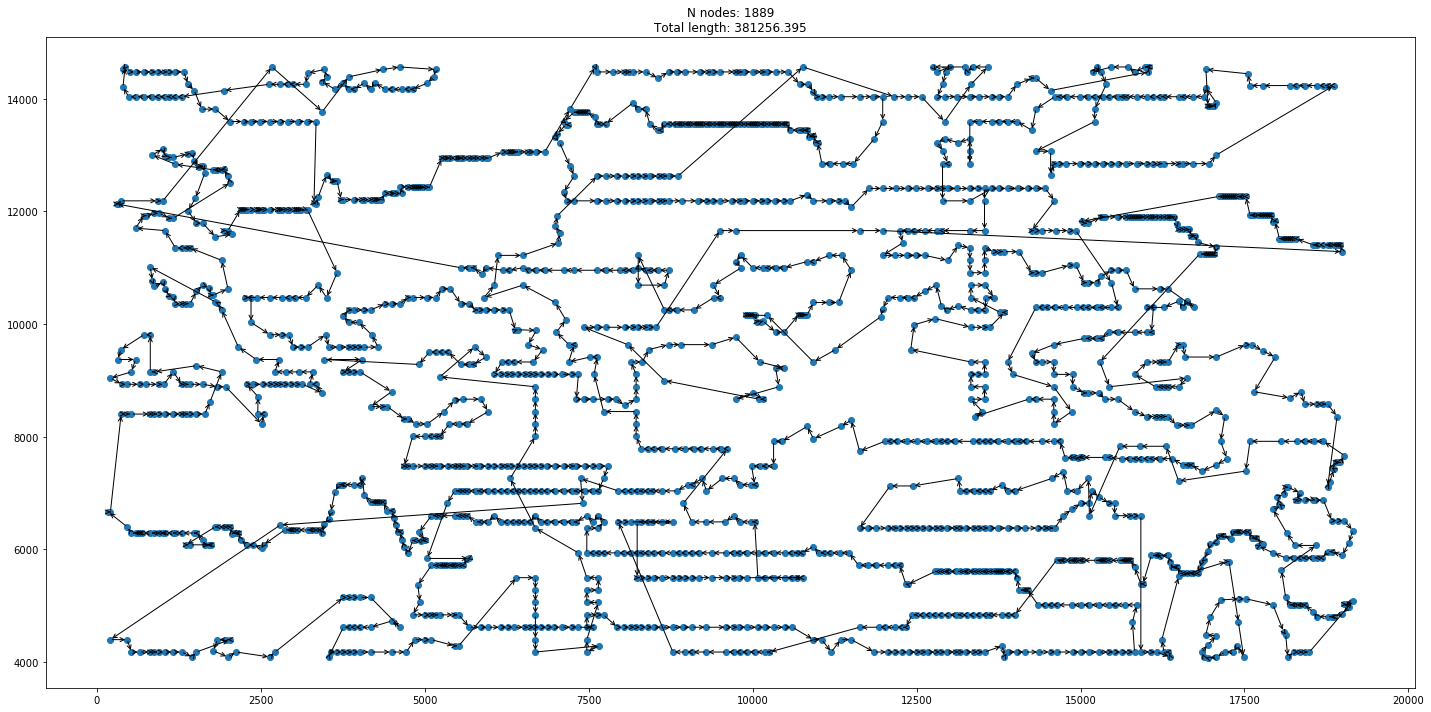

In [94]:
plot_tour(nodes_array, distance_matrix, solution_array)